# I. EDA - Exploratory Data Analysis
# 1. Setup and Data Loading (Common for all parts)

In [12]:
# --- 1. Setup and Data Loading ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
import pickle

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Load data (Adjust paths as per your environment)
try:
    train_df_raw = pd.read_csv('/kaggle/input/data-storm-6-0/train_storming_round.csv')
    test_df_raw = pd.read_csv('/kaggle/input/data-storm-6-0/test_storming_round.csv')
except FileNotFoundError:
    print("Kaggle specific paths not found. Using local paths as fallback (ensure they exist).")
    train_df_raw = pd.read_csv('train_storming_round.csv')
    test_df_raw = pd.read_csv('test_storming_round.csv')
print("Train Data Shape:", train_df_raw.shape)
test_df_raw.info()

Train Data Shape: (15308, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 914 entries, 0 to 913
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   row_id                           914 non-null    int64 
 1   agent_code                       914 non-null    object
 2   agent_age                        914 non-null    int64 
 3   agent_join_month                 914 non-null    object
 4   first_policy_sold_month          914 non-null    object
 5   year_month                       914 non-null    object
 6   unique_proposals_last_7_days     914 non-null    int64 
 7   unique_proposals_last_15_days    914 non-null    int64 
 8   unique_proposals_last_21_days    914 non-null    int64 
 9   unique_proposal                  914 non-null    int64 
 10  unique_quotations_last_7_days    914 non-null    int64 
 11  unique_quotations_last_15_days   914 non-null    int64 
 12  unique

# I.A. EDA Preprocessing

In [13]:
# --- I.A. EDA Preprocessing ---

def preprocess_for_eda(df):
    df_processed = df.copy()
    for col in ['agent_join_month', 'first_policy_sold_month', 'year_month']:
        if col in df_processed.columns:
            df_processed[col] = pd.to_datetime(df_processed[col], format='%m/%d/%Y', errors='coerce')

    if 'new_policy_count' in df_processed.columns:
        df_processed['is_NILL'] = (df_processed['new_policy_count'] == 0).astype(int)

    if not df_processed.empty and 'year_month' in df_processed.columns and 'agent_join_month' in df_processed.columns:
        reference_date_eda = df_processed['year_month'].max() + pd.DateOffset(months=1) if not df_processed['year_month'].empty else pd.to_datetime("2025-01-01")
        if 'agent_join_month' in df_processed.columns:
            df_processed['agent_tenure_months_eda'] = ((reference_date_eda - df_processed['agent_join_month']).dt.days // 30).fillna(0)
        if 'first_policy_sold_month' in df_processed.columns:
            df_processed['time_to_first_sale_months_eda'] = ((df_processed['first_policy_sold_month'] - df_processed['agent_join_month']).dt.days // 30)
            df_processed['months_since_first_sale_eda'] = ((reference_date_eda - df_processed['first_policy_sold_month']).dt.days // 30).fillna(0)
            df_processed.loc[df_processed['months_since_first_sale_eda'] < 0, 'months_since_first_sale_eda'] = 0

    if 'unique_proposal' in df_processed.columns and 'unique_customers' in df_processed.columns:
        df_processed['proposal_per_customer_eda'] = df_processed['unique_proposal'] / (df_processed['unique_customers'] + 1e-6)
    if 'unique_quotations' in df_processed.columns and 'unique_proposal' in df_processed.columns:
        df_processed['quotation_per_proposal_eda'] = df_processed['unique_quotations'] / (df_processed['unique_proposal'] + 1e-6)
    if 'new_policy_count' in df_processed.columns and 'unique_quotations' in df_processed.columns:
        df_processed['policies_per_quotation_eda'] = df_processed.get('new_policy_count', 0) / (df_processed['unique_quotations'] + 1e-6)
    return df_processed

train_eda_df = preprocess_for_eda(train_df_raw.copy())

# I.B. EDA 1: Key metrics and distributions

Train Data Description (Numerical Features for EDA):
             row_id     agent_age               agent_join_month  \
count  15308.000000  15308.000000                          15308   
mean    7654.500000     40.585772  2021-05-23 01:43:05.941991168   
min        1.000000     20.000000            2019-04-01 00:00:00   
25%     3827.750000     31.000000            2020-03-01 00:00:00   
50%     7654.500000     41.000000            2021-05-01 00:00:00   
75%    11481.250000     51.000000            2022-07-01 00:00:00   
max    15308.000000     60.000000            2024-07-01 00:00:00   
std     4419.183296     11.688204                            NaN   

             first_policy_sold_month                     year_month  \
count                          15308                          15308   
mean   2023-04-24 01:41:52.568591616  2023-11-03 05:31:24.191272704   
min              2022-01-01 00:00:00            2023-01-01 00:00:00   
25%              2022-10-01 00:00:00            20

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


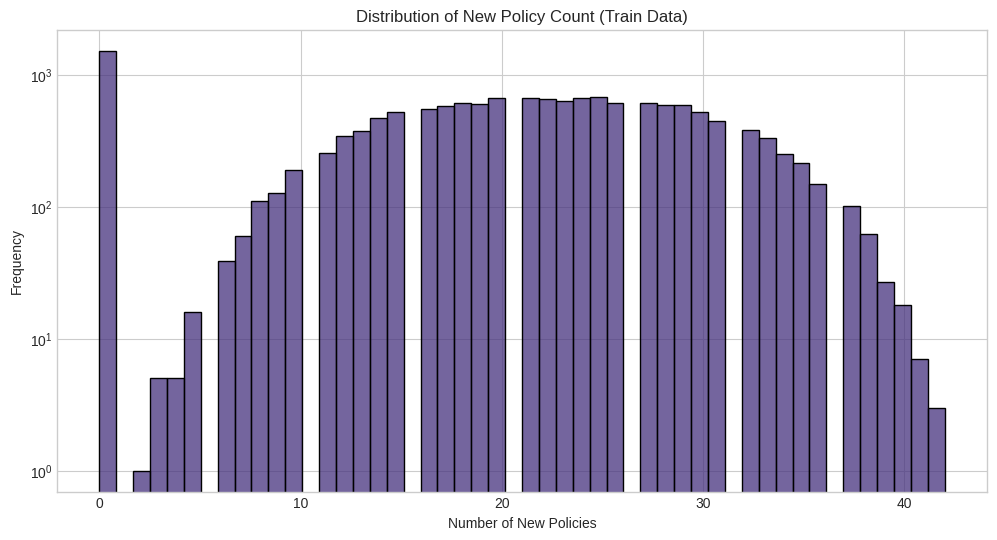

Percentage of NILL months in train_eda_df: 9.99%


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

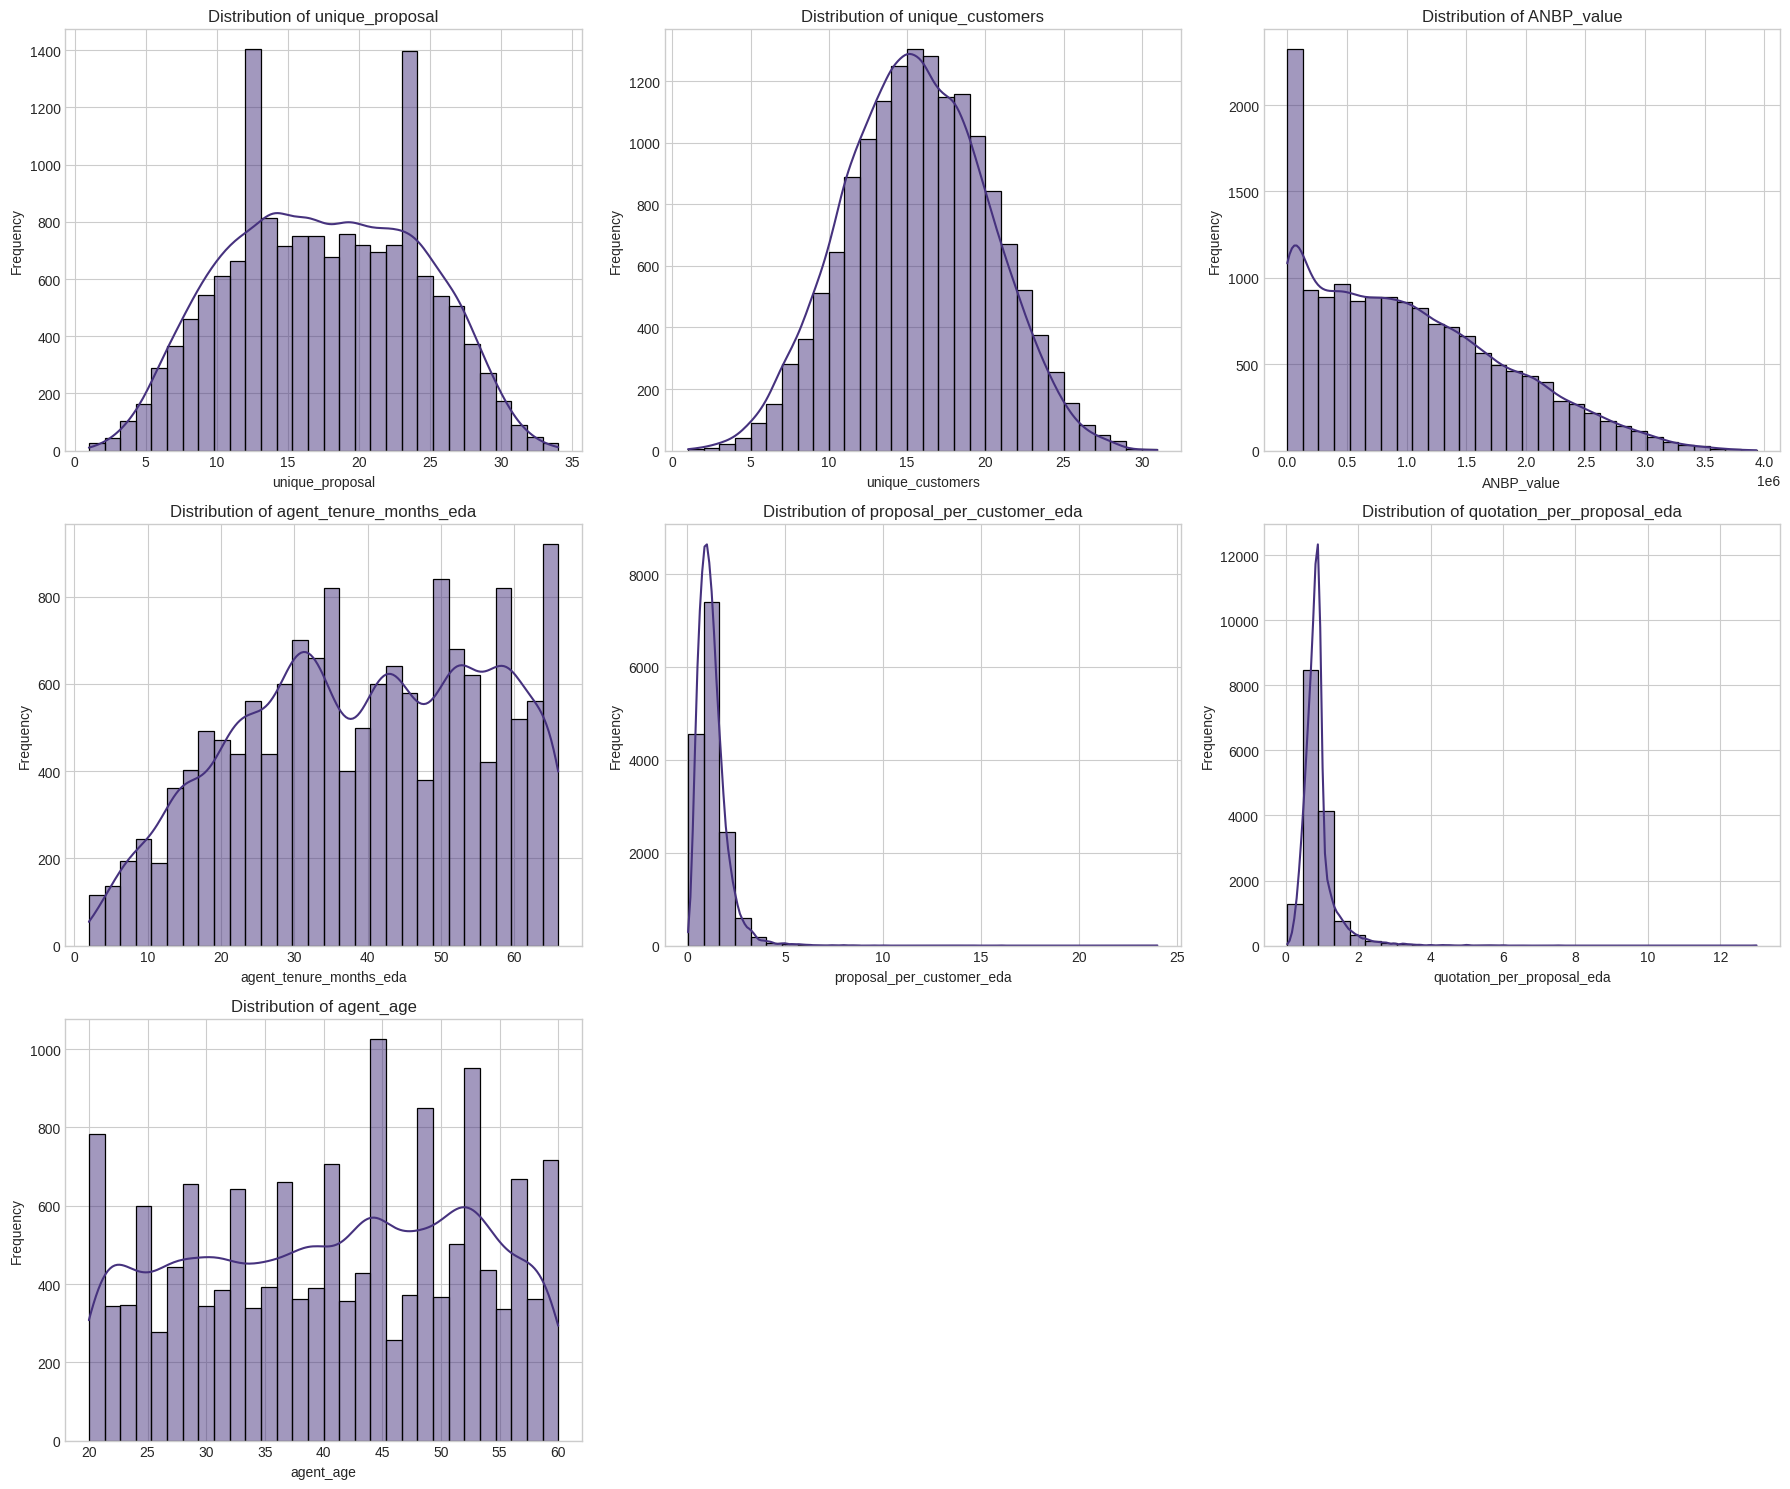

In [14]:
# --- I.B. EDA 1: Key metrics and distributions ---
print("Train Data Description (Numerical Features for EDA):")
print(train_eda_df.describe())

if 'new_policy_count' in train_eda_df.columns:
    plt.figure(figsize=(12, 6))
    sns.histplot(train_eda_df['new_policy_count'], bins=50, kde=False)
    plt.title('Distribution of New Policy Count (Train Data)')
    plt.xlabel('Number of New Policies'); plt.ylabel('Frequency'); plt.yscale('log')
    plt.show()
    if 'is_NILL' in train_eda_df.columns:
        print(f"Percentage of NILL months in train_eda_df: {train_eda_df['is_NILL'].mean()*100:.2f}%")

eda_numerical_cols = ['unique_proposal', 'unique_customers', 'ANBP_value',
                      'agent_tenure_months_eda', 'proposal_per_customer_eda', 
                      'quotation_per_proposal_eda', 'agent_age']
eda_numerical_cols = [col for col in eda_numerical_cols if col in train_eda_df.columns]

if eda_numerical_cols:
    num_plots = len(eda_numerical_cols); num_cols_plot = 3
    num_rows_plot = (num_plots + num_cols_plot - 1) // num_cols_plot
    fig, axes = plt.subplots(nrows=num_rows_plot, ncols=num_cols_plot, figsize=(18, 5 * num_rows_plot))
    axes = axes.flatten()
    for i, col in enumerate(eda_numerical_cols):
        sns.histplot(train_eda_df[col].dropna(), bins=30, kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}'); axes[i].set_xlabel(col); axes[i].set_ylabel('Frequency')
    for j in range(i + 1, len(axes)): fig.delaxes(axes[j])
    plt.tight_layout(); plt.show()

# I.C. EDA 2: Sales patterns by month

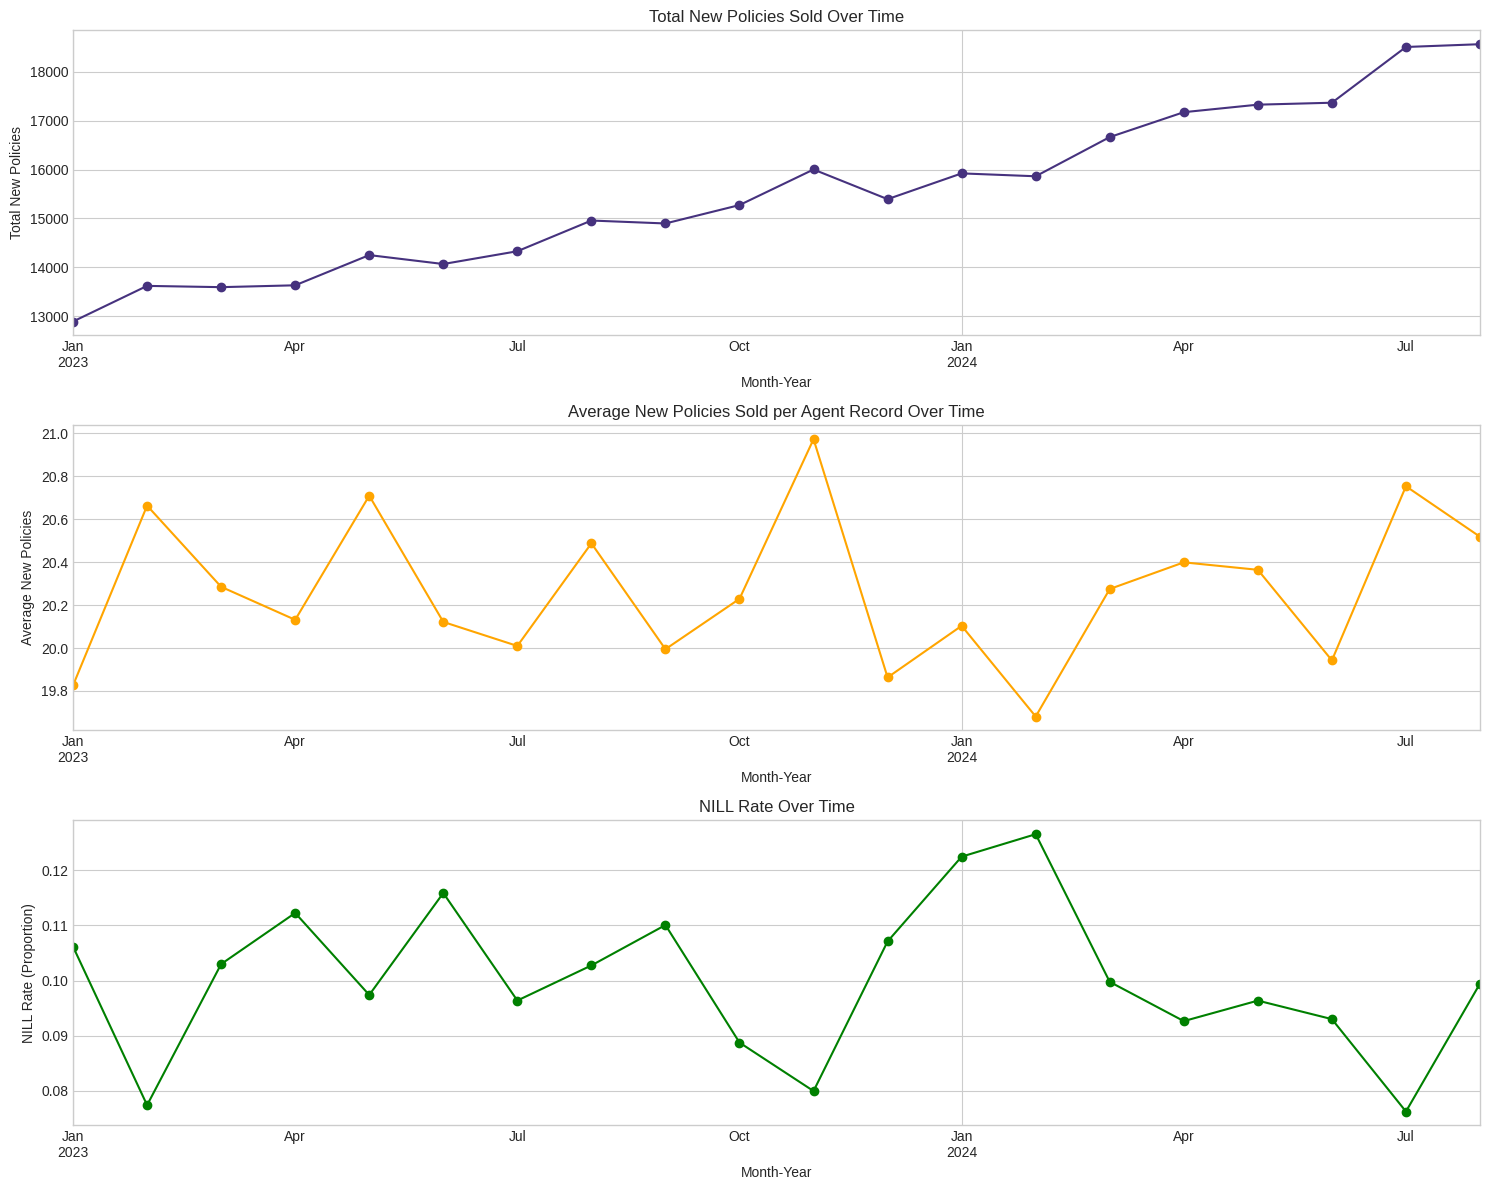

In [15]:
# --- I.C. EDA 2: Sales patterns by month ---
if 'year_month' in train_eda_df.columns and 'new_policy_count' in train_eda_df.columns:
    monthly_data = train_eda_df.sort_values('year_month')
    monthly_sales_sum = monthly_data.groupby('year_month')['new_policy_count'].sum()
    monthly_sales_avg = monthly_data.groupby('year_month')['new_policy_count'].mean()
    monthly_nill_rate = monthly_data.groupby('year_month')['is_NILL'].mean()

    plt.figure(figsize=(15, 12))
    plt.subplot(3, 1, 1); monthly_sales_sum.plot(kind='line', marker='o')
    plt.title('Total New Policies Sold Over Time'); plt.xlabel('Month-Year'); plt.ylabel('Total New Policies'); plt.grid(True)
    plt.subplot(3, 1, 2); monthly_sales_avg.plot(kind='line', marker='o', color='orange')
    plt.title('Average New Policies Sold per Agent Record Over Time'); plt.xlabel('Month-Year'); plt.ylabel('Average New Policies'); plt.grid(True)
    plt.subplot(3, 1, 3); monthly_nill_rate.plot(kind='line', marker='o', color='green')
    plt.title('NILL Rate Over Time'); plt.xlabel('Month-Year'); plt.ylabel('NILL Rate (Proportion)'); plt.grid(True)
    plt.tight_layout(); plt.show()

# I.D. EDA 3: Numerical feature interactions (Multivariate Analysis)

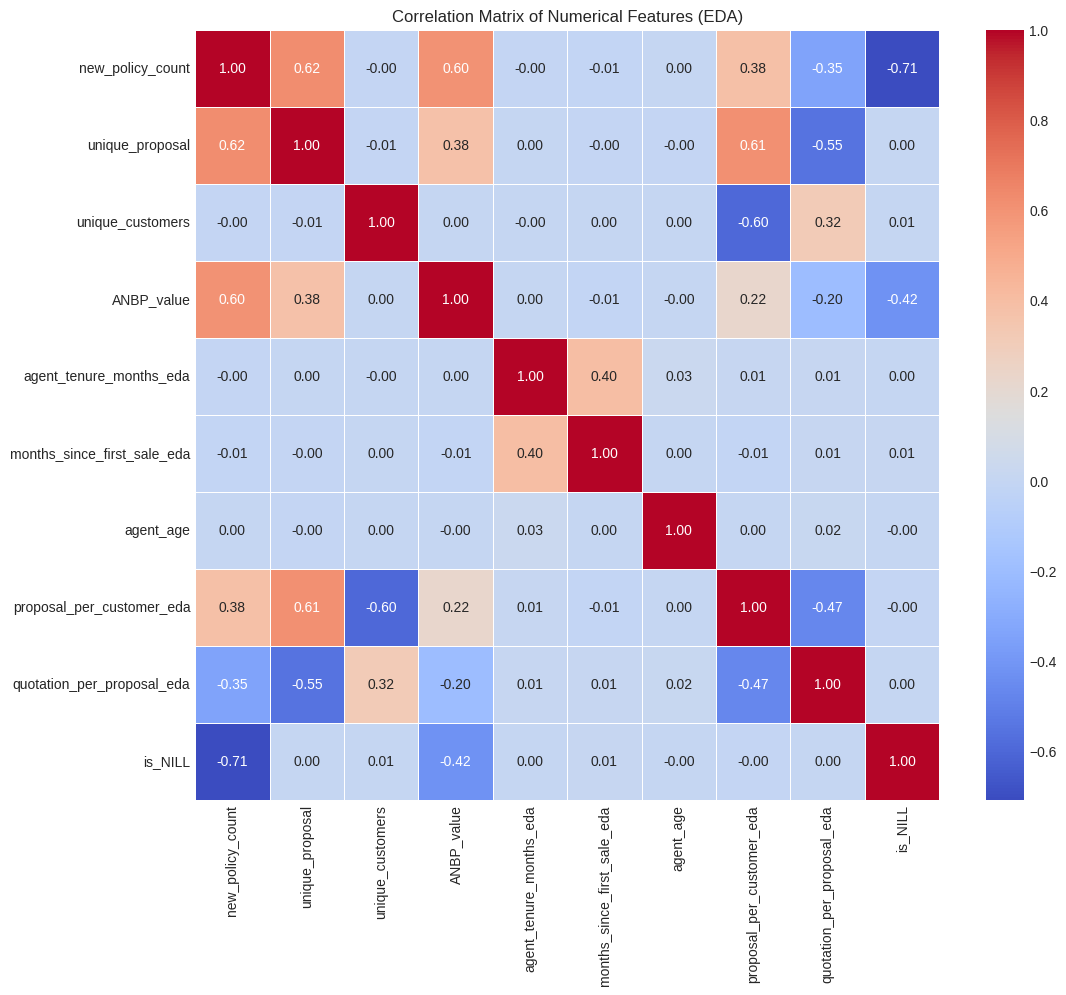

In [16]:
# --- I.D. EDA 3: Numerical feature interactions ---
eda_correlation_cols = ['new_policy_count', 'unique_proposal', 'unique_customers', 'ANBP_value',
                        'agent_tenure_months_eda', 'months_since_first_sale_eda', 'agent_age',
                        'proposal_per_customer_eda', 'quotation_per_proposal_eda', 'is_NILL']
eda_correlation_cols = [col for col in eda_correlation_cols if col in train_eda_df.columns and not train_eda_df[col].isnull().all()]

if len(eda_correlation_cols) > 1:
    plt.figure(figsize=(12, 10))
    correlation_matrix = train_eda_df[eda_correlation_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Matrix of Numerical Features (EDA)'); plt.show()

# I.E. EDA 4: Individual agent trajectories over time

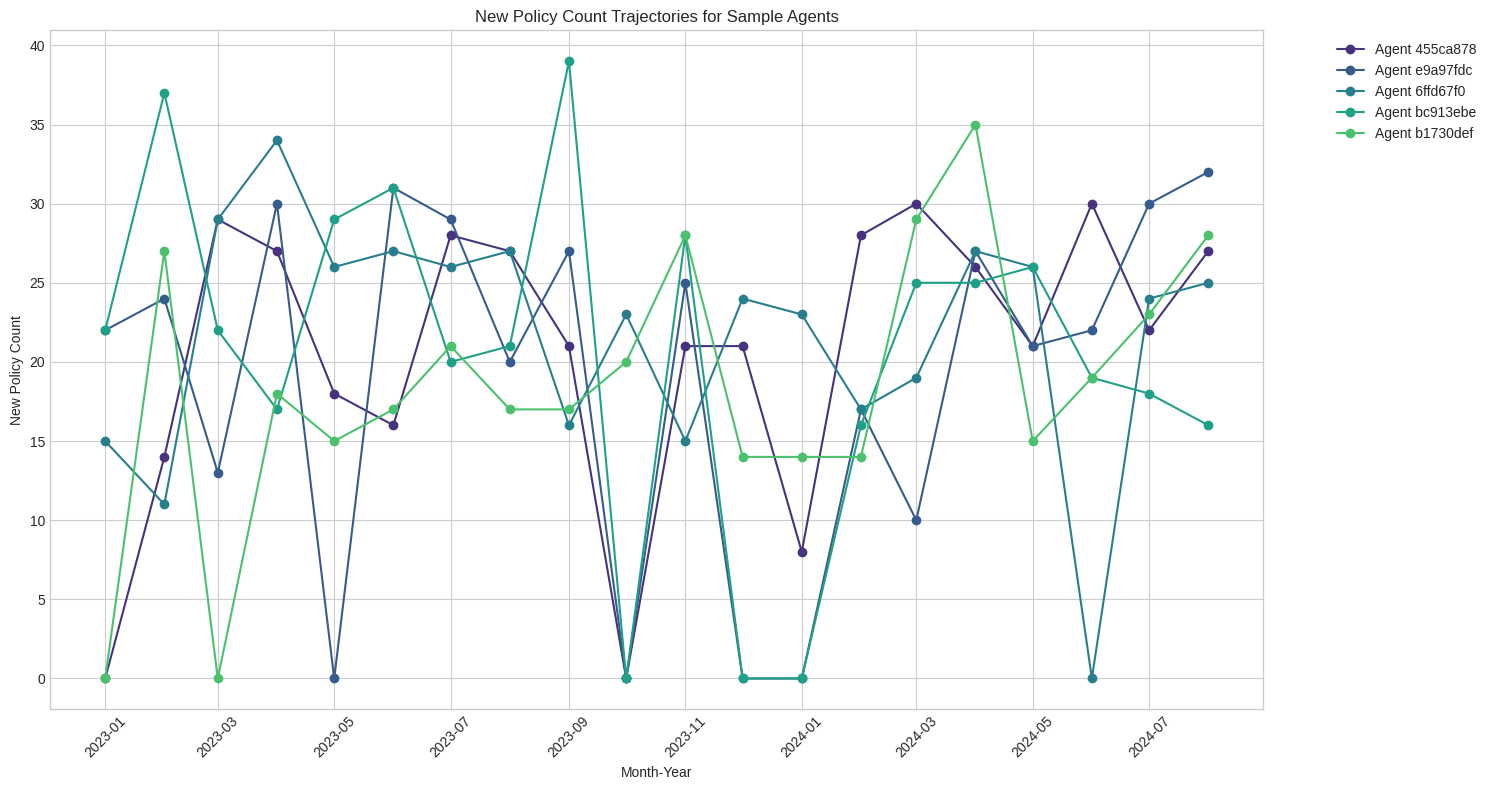

In [17]:
# --- I.E. EDA 4: Individual agent trajectories ---
if 'agent_code' in train_eda_df.columns and 'year_month' in train_eda_df.columns and 'new_policy_count' in train_eda_df.columns:
    sample_agent_codes = train_eda_df['agent_code'].value_counts().nlargest(5).index
    plt.figure(figsize=(15, 8))
    for agent_code_val in sample_agent_codes:
        agent_data = train_eda_df[train_eda_df['agent_code'] == agent_code_val].sort_values('year_month')
        plt.plot(agent_data['year_month'], agent_data['new_policy_count'], marker='o', linestyle='-', label=f'Agent {agent_code_val}')
    plt.title('New Policy Count Trajectories for Sample Agents'); plt.xlabel('Month-Year'); plt.ylabel('New Policy Count')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left'); plt.xticks(rotation=45); plt.grid(True); plt.tight_layout(); plt.show()

# I.F. EDA 5: Innovative EDA (Performance by Tenure, Time to First Sale)

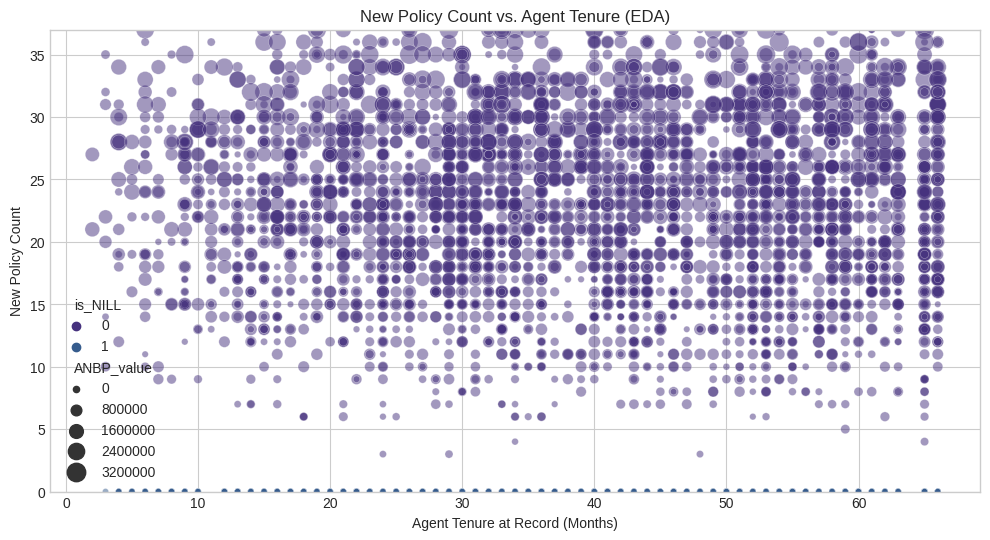

/tmp/ipykernel_31/2723294067.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tenure_performance_mean = train_eda_df.groupby('tenure_group_eda')['new_policy_count'].mean()
/tmp/ipykernel_31/2723294067.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tenure_nill_rate_mean = train_eda_df.groupby('tenure_group_eda')['is_NILL'].mean()


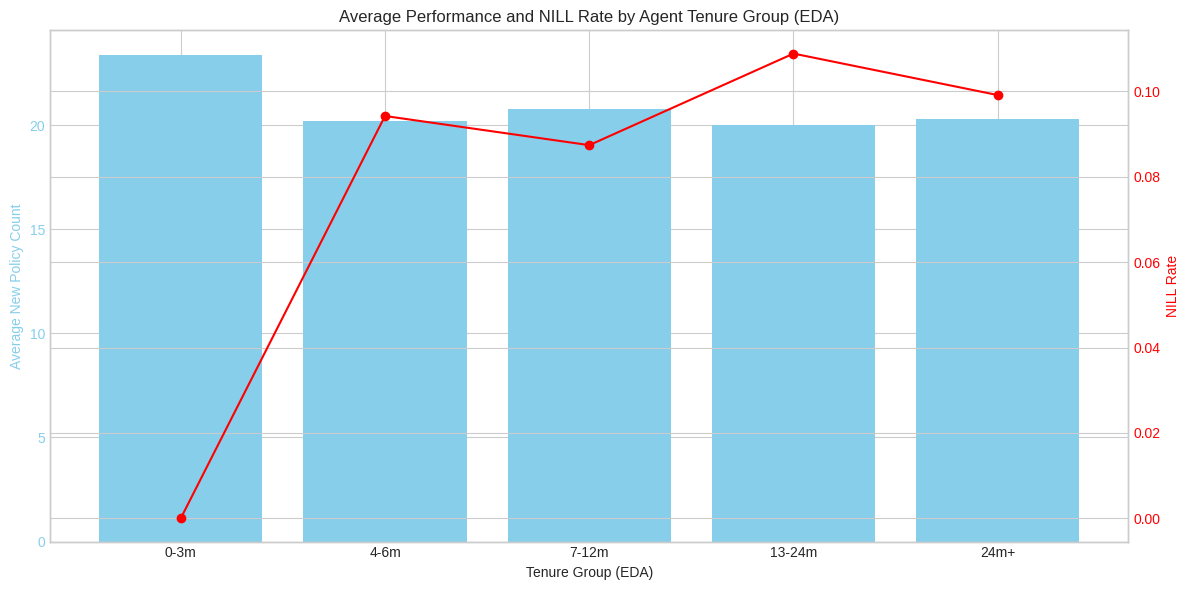

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


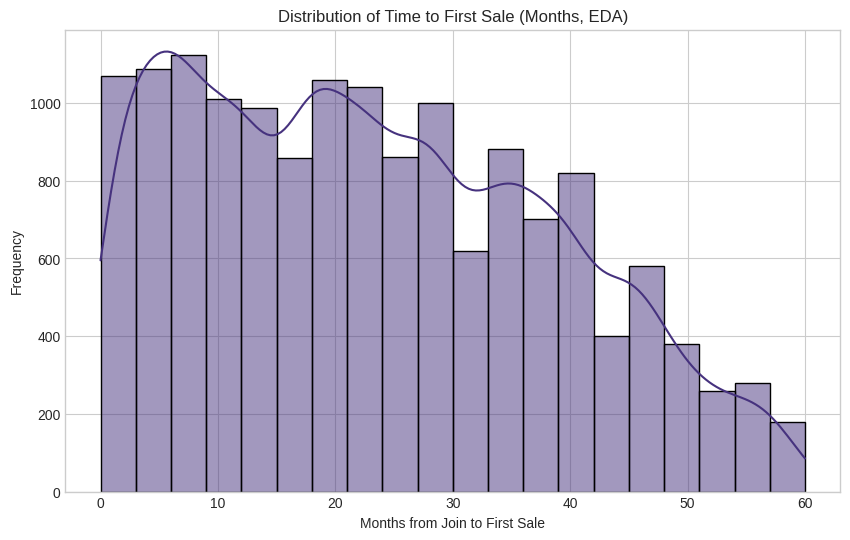

/tmp/ipykernel_31/2723294067.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_time_to_sale['time_to_first_sale_group_eda'] = pd.cut(valid_time_to_sale['time_to_first_sale_months_eda'], bins=sale_time_bins, labels=sale_time_labels, right=True)


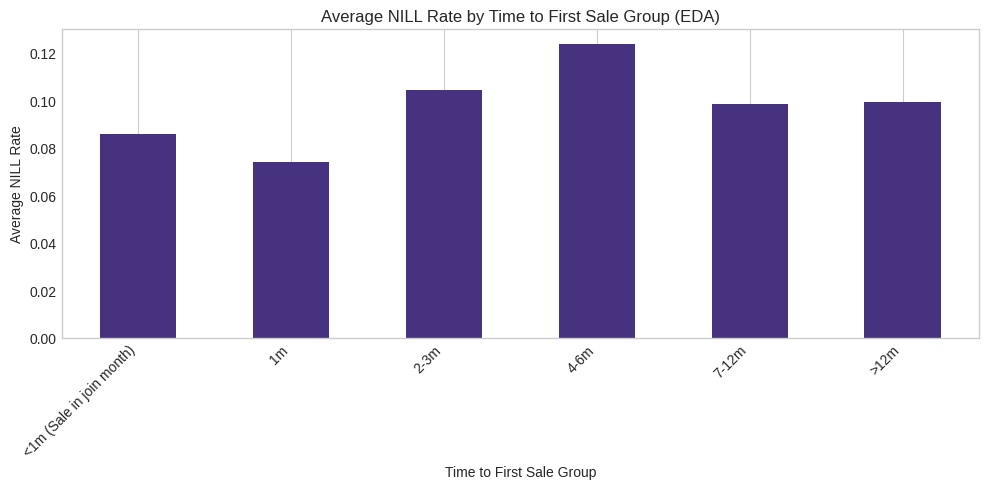

In [18]:
# --- I.F. EDA 5: Innovative EDA ---

# Tenure-Based Analysis
if 'agent_tenure_months_eda' in train_eda_df.columns and 'new_policy_count' in train_eda_df.columns:
    plt.figure(figsize=(12, 6))
    sample_df_eda = train_eda_df.sample(min(len(train_eda_df), 5000), random_state=42) if len(train_eda_df) > 5000 else train_eda_df
    sns.scatterplot(data=sample_df_eda, x='agent_tenure_months_eda', y='new_policy_count', alpha=0.5, 
                    hue='is_NILL' if 'is_NILL' in sample_df_eda.columns else None, 
                    size='ANBP_value' if 'ANBP_value' in sample_df_eda.columns else None, sizes=(20,200))
    plt.title('New Policy Count vs. Agent Tenure (EDA)'); plt.xlabel('Agent Tenure at Record (Months)'); plt.ylabel('New Policy Count')
    plt.ylim(0, train_eda_df['new_policy_count'].quantile(0.99) if train_eda_df['new_policy_count'].quantile(0.99) > 0 else 10); plt.grid(True); plt.show()

    max_tenure = train_eda_df['agent_tenure_months_eda'].max()
    if not pd.isna(max_tenure) and max_tenure > 0:
        bins = [0, 3, 6, 12, 24, max(25,max_tenure + 1)]; labels = ['0-3m', '4-6m', '7-12m', '13-24m', '24m+']
        train_eda_df['tenure_group_eda'] = pd.cut(train_eda_df['agent_tenure_months_eda'], bins=bins, labels=labels, right=False)
        if 'tenure_group_eda' in train_eda_df.columns:
            tenure_performance_mean = train_eda_df.groupby('tenure_group_eda')['new_policy_count'].mean()
            tenure_nill_rate_mean = train_eda_df.groupby('tenure_group_eda')['is_NILL'].mean()
            fig, ax1 = plt.subplots(figsize=(12,6))
            if not tenure_performance_mean.empty:
                ax1.bar(tenure_performance_mean.index.astype(str), tenure_performance_mean.values, color='skyblue', label='Avg Policies')
                ax1.set_xlabel('Tenure Group (EDA)'); ax1.set_ylabel('Average New Policy Count', color='skyblue'); ax1.tick_params(axis='y', labelcolor='skyblue')
            if not tenure_nill_rate_mean.empty:
                ax2 = ax1.twinx()
                ax2.plot(tenure_nill_rate_mean.index.astype(str), tenure_nill_rate_mean.values, color='red', marker='o', label='NILL Rate')
                ax2.set_ylabel('NILL Rate', color='red'); ax2.tick_params(axis='y', labelcolor='red')
            plt.title('Average Performance and NILL Rate by Agent Tenure Group (EDA)'); fig.tight_layout(); plt.show()

# Time to First Sale Analysis
if 'time_to_first_sale_months_eda' in train_eda_df.columns and 'is_NILL' in train_eda_df.columns:
    valid_time_to_sale = train_eda_df[train_eda_df['time_to_first_sale_months_eda'].notna() & (train_eda_df['time_to_first_sale_months_eda'] >= 0)]
    if not valid_time_to_sale.empty:
        plt.figure(figsize=(10, 6)); sns.histplot(valid_time_to_sale['time_to_first_sale_months_eda'], bins=20, kde=True)
        plt.title('Distribution of Time to First Sale (Months, EDA)'); plt.xlabel('Months from Join to First Sale'); plt.ylabel('Frequency'); plt.grid(True); plt.show()
        max_time_to_sale = valid_time_to_sale['time_to_first_sale_months_eda'].max()
        if not pd.isna(max_time_to_sale) and max_time_to_sale > 0:
            sale_time_bins = [-1, 0, 1, 3, 6, 12, max(13, int(max_time_to_sale) + 1)] # Ensure bins cover max
            sale_time_labels = ['<1m (Sale in join month)', '1m', '2-3m', '4-6m', '7-12m', '>12m']
            if len(sale_time_labels) != len(sale_time_bins) -1 : sale_time_bins = [-1, 0, 1, 3, 6, 12, float('inf')] # Fallback
            valid_time_to_sale['time_to_first_sale_group_eda'] = pd.cut(valid_time_to_sale['time_to_first_sale_months_eda'], bins=sale_time_bins, labels=sale_time_labels, right=True)
            if 'time_to_first_sale_group_eda' in valid_time_to_sale.columns:
                avg_nill_by_time_to_sale = valid_time_to_sale.groupby('time_to_first_sale_group_eda', observed=False)['is_NILL'].mean()
                if not avg_nill_by_time_to_sale.empty:
                    avg_nill_by_time_to_sale.plot(kind='bar', figsize=(10,5))
                    plt.title('Average NILL Rate by Time to First Sale Group (EDA)'); plt.ylabel('Average NILL Rate'); plt.xlabel('Time to First Sale Group')
                    plt.xticks(rotation=45, ha='right'); plt.grid(axis='y'); plt.tight_layout(); plt.show()

# II. Part 1 - Predict NILL Agents
# II.A. Feature Engineering for NILL Prediction Model

In [19]:
# --- II.A. Feature Engineering for NILL Prediction Model ---
def create_features_for_model(df, ref_date_str="2025-01-01"):
    X = df.copy()
    for col in ['agent_join_month', 'first_policy_sold_month', 'year_month']:
        if col in X.columns: X[col] = pd.to_datetime(X[col], format='%m/%d/%Y', errors='coerce')
        else: X[col] = pd.NaT

    if 'year_month' in X.columns and 'agent_join_month' in X.columns:
        X['agent_tenure_at_record_months'] = ((X['year_month'] - X['agent_join_month']).dt.days // 30).fillna(0)
        X.loc[X['agent_tenure_at_record_months'] < 0, 'agent_tenure_at_record_months'] = 0
    else: X['agent_tenure_at_record_months'] = 0

    if 'year_month' in X.columns and 'first_policy_sold_month' in X.columns:
        X['months_since_first_sale_at_record'] = ((X['year_month'] - X['first_policy_sold_month']).dt.days // 30).fillna(-1)
        X.loc[X['months_since_first_sale_at_record'] < 0, 'months_since_first_sale_at_record'] = -1
    else: X['months_since_first_sale_at_record'] = -1
    
    fixed_ref_date = pd.to_datetime(ref_date_str)
    if 'agent_join_month' in X.columns:
        X['months_since_joined_fixed_ref'] = (fixed_ref_date - X['agent_join_month']).dt.days // 30
        X['months_since_joined_fixed_ref'] = X['months_since_joined_fixed_ref'].fillna(X['months_since_joined_fixed_ref'].median() if not X['months_since_joined_fixed_ref'].isnull().all() else 0)
    else: X['months_since_joined_fixed_ref'] = 0

    if 'first_policy_sold_month' in X.columns:
        X['months_since_first_sale_fixed_ref'] = (fixed_ref_date - X['first_policy_sold_month']).dt.days // 30
        X['months_since_first_sale_fixed_ref'] = X['months_since_first_sale_fixed_ref'].fillna(-1)
    else: X['months_since_first_sale_fixed_ref'] = -1

    for col_name in ['unique_proposal', 'unique_customers', 'unique_quotations']:
        if col_name not in X.columns: X[col_name] = 0
    X['proposal_per_customer'] = X['unique_proposal'] / (X['unique_customers'] + 1e-6)
    X['quotation_per_proposal'] = X['unique_quotations'] / (X['unique_proposal'] + 1e-6)

    for col_prefix, date_col_name in [('join', 'agent_join_month'), ('first_sale', 'first_policy_sold_month'), ('record', 'year_month')]:
        if date_col_name in X.columns and pd.api.types.is_datetime64_any_dtype(X[date_col_name]):
            X[f'{col_prefix}_year'] = X[date_col_name].dt.year; X[f'{col_prefix}_month_of_year'] = X[date_col_name].dt.month
            X[f'{col_prefix}_day_of_year'] = X[date_col_name].dt.dayofyear; X[f'{col_prefix}_week_of_year'] = X[date_col_name].dt.isocalendar().week.astype(int)
        else: 
            X[f'{col_prefix}_year'], X[f'{col_prefix}_month_of_year'], X[f'{col_prefix}_day_of_year'], X[f'{col_prefix}_week_of_year'] = 0,0,0,0
            
    if 'agent_tenure_at_record_months' in X.columns and 'unique_proposal' in X.columns:
        X['tenure_x_proposals'] = X['agent_tenure_at_record_months'] * X['unique_proposal']
    else: X['tenure_x_proposals'] = 0

    raw_features_to_include = ['agent_age', 'unique_proposals_last_7_days', 'unique_proposals_last_15_days',
        'unique_proposals_last_21_days', 'unique_quotations_last_7_days', 'unique_quotations_last_15_days',
        'unique_quotations_last_21_days', 'unique_customers_last_7_days', 'unique_customers_last_15_days',
        'unique_customers_last_21_days', 'ANBP_value', 'net_income', 'number_of_policy_holders', 
        'number_of_cash_payment_policies', 'unique_proposal', 'unique_quotations', 'unique_customers']
    for col in raw_features_to_include:
        if col not in X.columns: X[col] = 0

    potential_feature_cols = ['agent_tenure_at_record_months', 'months_since_first_sale_at_record', 'months_since_joined_fixed_ref', 
        'months_since_first_sale_fixed_ref', 'proposal_per_customer', 'quotation_per_proposal', 'join_year', 'join_month_of_year', 
        'join_day_of_year', 'join_week_of_year', 'first_sale_year', 'first_sale_month_of_year', 'first_sale_day_of_year', 
        'first_sale_week_of_year', 'record_year', 'record_month_of_year', 'record_day_of_year', 'record_week_of_year', 
        'tenure_x_proposals'] + raw_features_to_include
    final_feature_cols = sorted(list(set(col for col in potential_feature_cols if col in X.columns)))
    return X[final_feature_cols]

X_train_model = create_features_for_model(train_df_raw.copy())
y_train_model = (train_df_raw['new_policy_count'] > 0).astype(int)
X_test_model = create_features_for_model(test_df_raw.copy())

training_feature_names = X_train_model.columns.tolist()
for col in training_feature_names:
    if col not in X_test_model.columns: X_test_model[col] = -1
X_test_model = X_test_model[training_feature_names]

X_train_model = X_train_model.fillna(-1)
X_test_model = X_test_model.fillna(-1)

print("Features for NILL model (order matters):", X_train_model.columns.tolist())
# This list should be used for `expected_features` in the dashboard.

Features for NILL model (order matters): ['ANBP_value', 'agent_age', 'agent_tenure_at_record_months', 'first_sale_day_of_year', 'first_sale_month_of_year', 'first_sale_week_of_year', 'first_sale_year', 'join_day_of_year', 'join_month_of_year', 'join_week_of_year', 'join_year', 'months_since_first_sale_at_record', 'months_since_first_sale_fixed_ref', 'months_since_joined_fixed_ref', 'net_income', 'number_of_cash_payment_policies', 'number_of_policy_holders', 'proposal_per_customer', 'quotation_per_proposal', 'record_day_of_year', 'record_month_of_year', 'record_week_of_year', 'record_year', 'tenure_x_proposals', 'unique_customers', 'unique_customers_last_15_days', 'unique_customers_last_21_days', 'unique_customers_last_7_days', 'unique_proposal', 'unique_proposals_last_15_days', 'unique_proposals_last_21_days', 'unique_proposals_last_7_days', 'unique_quotations', 'unique_quotations_last_15_days', 'unique_quotations_last_21_days', 'unique_quotations_last_7_days']


# II.B. Trained Prediction Model (NILL Prediction - Kaggle Problem)

In [20]:
# --- II.B. Trained Prediction Model (NILL Prediction) ---
model_nill = xgb.XGBClassifier(
    n_estimators=300, max_depth=7, learning_rate=0.05, subsample=0.8,
    colsample_bytree=0.8, use_label_encoder=False, eval_metric='logloss', random_state=42
)
model_nill.fit(X_train_model, y_train_model)
print("NILL Prediction Model trained.")

model_save_path = 'nill_prediction_model.pkl' # Or 'model/nill_prediction_model.pkl'
with open(model_save_path, 'wb') as f: pickle.dump(model_nill, f)
print(f"Model saved to {model_save_path}")

test_probs_nill = model_nill.predict_proba(X_test_model)[:, 1]
flip_count = 94 
test_preds_final_submission = np.ones(len(test_df_raw), dtype=int)
lowest_prob_indices = np.argsort(test_probs_nill)[:flip_count]
test_preds_final_submission[lowest_prob_indices] = 0

submission_df = pd.DataFrame({'row_id': test_df_raw['row_id'], 'target_column': test_preds_final_submission})
submission_df.to_csv('submission_nill_prediction.csv', index=False)
print("Submission file 'submission_nill_prediction.csv' created.")
print("Value counts in submission:", submission_df['target_column'].value_counts(normalize=True))

NILL Prediction Model trained.
Model saved to nill_prediction_model.pkl
Submission file 'submission_nill_prediction.csv' created.
Value counts in submission: target_column
1    0.897155
0    0.102845
Name: proportion, dtype: float64


# II.C. List of Top Factors Affecting Early Performance (NILL Risk)

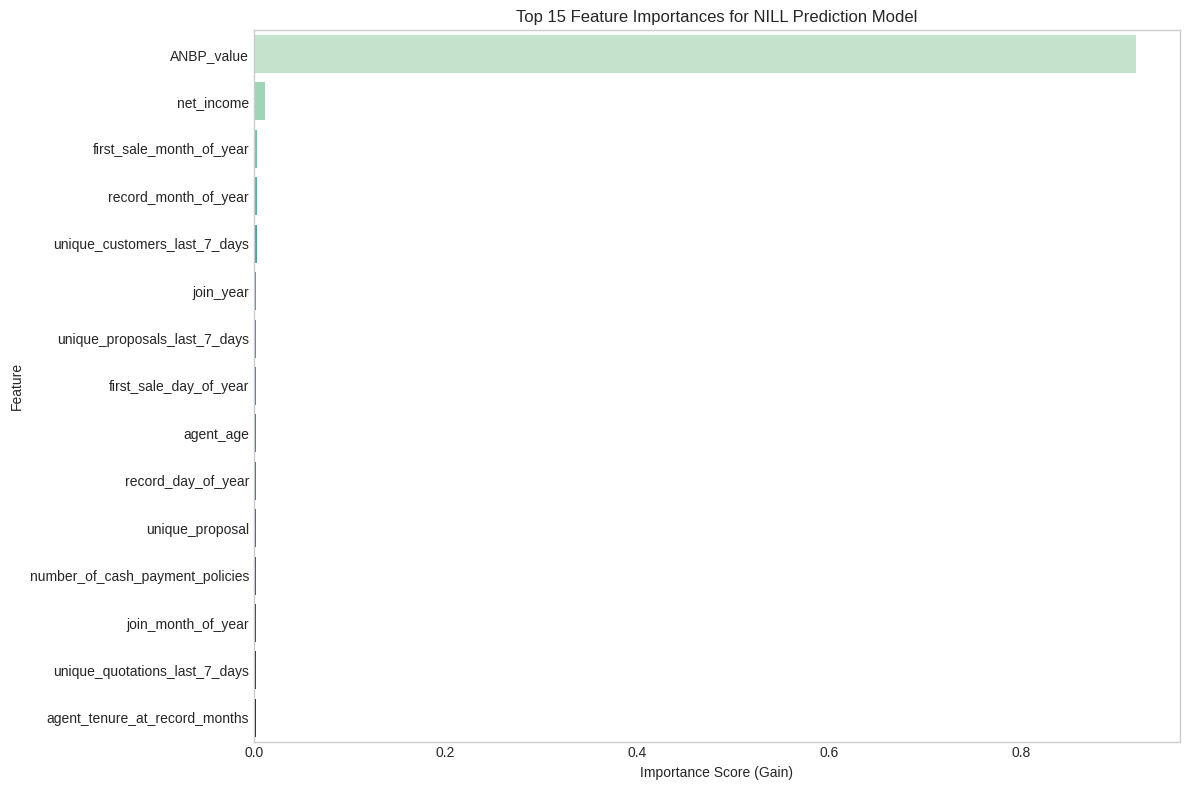


Top Factors Affecting NILL Risk:
- ANBP_value: 0.9196
- net_income: 0.0118
- first_sale_month_of_year: 0.0031
- record_month_of_year: 0.0030
- unique_customers_last_7_days: 0.0029
- join_year: 0.0028
- unique_proposals_last_7_days: 0.0028
- first_sale_day_of_year: 0.0025
- agent_age: 0.0025
- record_day_of_year: 0.0024
- unique_proposal: 0.0022
- number_of_cash_payment_policies: 0.0022
- join_month_of_year: 0.0022
- unique_quotations_last_7_days: 0.0022
- agent_tenure_at_record_months: 0.0022


In [21]:
# --- II.C. List of Top Factors Affecting NILL Risk ---
importances = model_nill.feature_importances_
feature_names_from_model = X_train_model.columns
feature_importance_df = pd.DataFrame({'feature': feature_names_from_model, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False).head(15)

plt.figure(figsize=(12, 8)); sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='mako_r')
plt.title('Top 15 Feature Importances for NILL Prediction Model'); plt.xlabel('Importance Score (Gain)'); plt.ylabel('Feature')
plt.grid(axis='x'); plt.tight_layout(); plt.show()

print("\nTop Factors Affecting NILL Risk:")
for _, row_fi in feature_importance_df.iterrows(): print(f"- {row_fi['feature']}: {row_fi['importance']:.4f}")

# II.D. Personalized Action Plan Recommendation System for At-Risk Agents

In [22]:
# --- II.D. Personalized Action Plan Recommendation System ---
at_risk_test_row_ids = submission_df[submission_df['target_column'] == 0]['row_id']
at_risk_agents_original_details = test_df_raw[test_df_raw['row_id'].isin(at_risk_test_row_ids)].copy()

row_id_to_idx_map = pd.Series(test_df_raw.index, index=test_df_raw.row_id)
indices_for_at_risk_features = row_id_to_idx_map[at_risk_test_row_ids].dropna().astype(int) # Ensure indices are valid
at_risk_agents_model_features_indexed = X_test_model.iloc[indices_for_at_risk_features]

def recommend_smart_action_plan(agent_original_data_row, agent_model_features_row, top_fi_df):
    actions = []; agent_id = agent_original_data_row.get('agent_code', 'Unknown Agent')
    original_year_month_val = agent_original_data_row.get('year_month') 
    if pd.notnull(original_year_month_val) and not isinstance(original_year_month_val, str): record_month_dt = original_year_month_val
    elif isinstance(original_year_month_val, str): record_month_dt = pd.to_datetime(original_year_month_val, format='%m/%d/%Y', errors='coerce')
    else: record_month_dt = pd.Timestamp.now()
    next_month_str = (record_month_dt + pd.DateOffset(months=1)).strftime('%Y-%B') if pd.notnull(record_month_dt) else "the next month"
    actions.append(f"SMART Action Plan for Agent {agent_id} (for {next_month_str}):\nOverall Goal: Achieve at least 1 policy sale next month.\n")

    proposal_feature_to_check = None
    if 'unique_proposals_last_7_days' in agent_model_features_row.index and 'unique_proposals_last_7_days' in top_fi_df['feature'].values: proposal_feature_to_check = 'unique_proposals_last_7_days'
    elif 'unique_proposal' in agent_model_features_row.index and 'unique_proposal' in top_fi_df['feature'].values: proposal_feature_to_check = 'unique_proposal'
    if proposal_feature_to_check and agent_model_features_row[proposal_feature_to_check] < 2:
        actions.append(f"**Focus: Increase Recent Proposal Volume ({proposal_feature_to_check})**\n  - S: Increase unique proposals (recent activity).\n  - M: Target >=5 {proposal_feature_to_check} in next 2 weeks.\n  - A: Extra hour daily for leads/proposals. Review templates.\n  - R: More recent proposals = more sales ops.\n  - T: By mid-{next_month_str}.\n")

    customer_feature_to_check = None
    if 'unique_customers_last_7_days' in agent_model_features_row.index and 'unique_customers_last_7_days' in top_fi_df['feature'].values: customer_feature_to_check = 'unique_customers_last_7_days'
    elif 'unique_customers' in agent_model_features_row.index and 'unique_customers' in top_fi_df['feature'].values: customer_feature_to_check = 'unique_customers'
    if customer_feature_to_check and agent_model_features_row[customer_feature_to_check] < 2:
        actions.append(f"**Focus: Broaden Recent Customer Outreach ({customer_feature_to_check})**\n  - S: Engage more unique customers recently.\n  - M: Interact meaningfully with >=3 new unique customers/week.\n  - A: Use CRM, ask referrals, explore new lead source.\n  - R: More customer interactions = more sales.\n  - T: Track weekly, review at month-end ({next_month_str}).\n")
    
    tenure_feat_model = 'agent_tenure_at_record_months'
    if tenure_feat_model in agent_model_features_row.index and agent_model_features_row[tenure_feat_model] <= 3:
        actions.append(f"**Focus: Foundational Skills & Mentorship (New Agent - {agent_model_features_row[tenure_feat_model]:.0f}m tenure)**\n  - S: Strengthen product/sales knowledge.\n  - M: Complete 2 trainings, shadow 3 calls.\n  - A: Schedule time with mentor/manager.\n  - R: Crucial for early success.\n  - T: Within first two weeks of {next_month_str}.\n")
    
    if len(actions) == 1: # Only header and goal added
        actions.append(f"**Focus: General Sales Activity & Strategy Review**\n  - S: Review past month's pipeline/activities/conversions for bottlenecks.\n  - M: Discuss 3 challenging cases/lost ops with mentor; ID 2 actionable improvements.\n  - A: Schedule 1hr review early in {next_month_str}.\n  - R: Proactive review/adjustment improves effectiveness.\n  - T: Implement improvements throughout {next_month_str}.\n")
    actions.append("**Generic Support Reminders:**\n  - Attend sales meetings/trainings.\n  - Seek regular feedback.\n  - Review best practices.")
    return "\n".join(actions)

print("\n--- Example Personalized Action Plans for At-Risk Agents ---")
num_examples_to_show = min(3, len(at_risk_test_row_ids))
if num_examples_to_show > 0 and len(at_risk_agents_original_details) >= num_examples_to_show and len(at_risk_agents_model_features_indexed) >= num_examples_to_show :
    sample_at_risk_original_details = at_risk_agents_original_details.iloc[:num_examples_to_show]
    sample_at_risk_model_features = at_risk_agents_model_features_indexed.iloc[:num_examples_to_show]
    for i in range(num_examples_to_show):
        agent_orig_row = sample_at_risk_original_details.iloc[i]
        agent_model_feat_row = sample_at_risk_model_features.iloc[i] 
        plan = recommend_smart_action_plan(agent_orig_row, agent_model_feat_row, feature_importance_df)
        print(plan); print("--------------------\n")


--- Example Personalized Action Plans for At-Risk Agents ---
SMART Action Plan for Agent 9e6b324e (for 2024-October):
Overall Goal: Achieve at least 1 policy sale next month.

**Focus: Broaden Recent Customer Outreach (unique_customers_last_7_days)**
  - S: Engage more unique customers recently.
  - M: Interact meaningfully with >=3 new unique customers/week.
  - A: Use CRM, ask referrals, explore new lead source.
  - R: More customer interactions = more sales.
  - T: Track weekly, review at month-end (2024-October).

**Generic Support Reminders:**
  - Attend sales meetings/trainings.
  - Seek regular feedback.
  - Review best practices.
--------------------

SMART Action Plan for Agent 3df612f0 (for 2024-October):
Overall Goal: Achieve at least 1 policy sale next month.

**Focus: General Sales Activity & Strategy Review**
  - S: Review past month's pipeline/activities/conversions for bottlenecks.
  - M: Discuss 3 challenging cases/lost ops with mentor; ID 2 actionable improvements.
 

# III. Part 2 - Monitor and Improve Existing Agent Performance
# III.A. Method to Classify Current Agent Performance (Low, Medium, High)


Agent Historical Performance Classification:
   agent_code  total_policies_historical  months_active_historical  \
0   003c1999                        448                        20   
1   00d5bda3                        405                        20   
2   012a3553                        362                        20   
3   012f0e15                        393                        20   
4   0177ed5f                        425                        20   

   avg_policies_per_month_historical  nill_months_historical  \
0                              22.40                       2   
1                              20.25                       5   
2                              18.10                       3   
3                              19.65                       3   
4                              21.25                       1   

   nill_rate_historical performance_category_historical  
0                  0.10                            High  
1                  0.25              

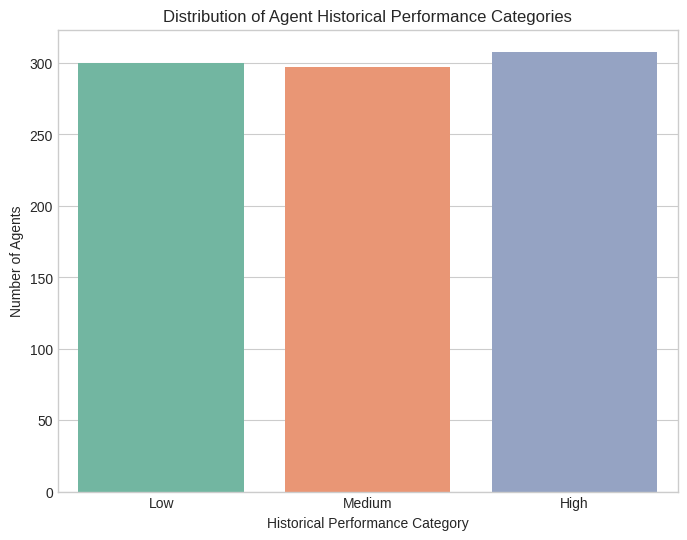

In [23]:
# --- III.A. Method to Classify Agent Performance ---
if 'new_policy_count' in train_df_raw.columns and 'agent_code' in train_df_raw.columns:
    agent_performance_summary = train_df_raw.groupby('agent_code').agg(
        total_policies_historical = ('new_policy_count', 'sum'),
        months_active_historical = ('row_id', 'count'),
        avg_policies_per_month_historical = ('new_policy_count', 'mean'),
        nill_months_historical = ('new_policy_count', lambda x: (x == 0).sum())
    ).reset_index()
    agent_performance_summary['nill_rate_historical'] = agent_performance_summary['nill_months_historical'] / agent_performance_summary['months_active_historical']

    if len(agent_performance_summary) >=3:
        quantiles = agent_performance_summary['avg_policies_per_month_historical'].quantile([0.33, 0.66]).tolist()
        if pd.isna(quantiles[0]) or pd.isna(quantiles[1]) or quantiles[0] == quantiles[1]:
            median_perf = agent_performance_summary['avg_policies_per_month_historical'].median()
            low_threshold_perf = median_perf * 0.5 if median_perf > 0 else 0.1 
            high_threshold_perf = median_perf * 1.5 if median_perf > 0 else 0.5
            if low_threshold_perf >= high_threshold_perf : high_threshold_perf = low_threshold_perf + 0.1
        else: low_threshold_perf, high_threshold_perf = quantiles[0], quantiles[1]
    else: low_threshold_perf, high_threshold_perf = 0.5, 1.5

    def classify_historical_performance(avg_policies):
        if avg_policies <= low_threshold_perf: return 'Low'
        elif avg_policies <= high_threshold_perf: return 'Medium'
        else: return 'High'
    agent_performance_summary['performance_category_historical'] = agent_performance_summary['avg_policies_per_month_historical'].apply(classify_historical_performance)

    print("\nAgent Historical Performance Classification:\n", agent_performance_summary.head())
    print("\nHistorical Performance Category Counts:\n", agent_performance_summary['performance_category_historical'].value_counts())
    plt.figure(figsize=(8, 6)); sns.countplot(data=agent_performance_summary, x='performance_category_historical', order=['Low', 'Medium', 'High'], palette='Set2')
    plt.title('Distribution of Agent Historical Performance Categories'); plt.xlabel('Historical Performance Category'); plt.ylabel('Number of Agents'); plt.show()

# III.B. Intervention Strategy Based on Performance Category

In [24]:
# --- III.B. Intervention Strategy Based on Performance Category ---
def recommend_interventions_for_category(category, agent_code_example="[Agent Sample]"):
    interventions = f"General Intervention Strategy for {agent_code_example} ({category} Performer based on history):\n"
    if category == 'Low': interventions += ("- **Focus:** Foundational Skill Building, Activity Increase, & Close Monitoring.\n- **Actions:**\n  1. Diagnostic Review.\n  2. Mandatory Retraining.\n  3. Structured Mentorship.\n  4. Clear Activity Goals.\n  5. Regular Performance Review.\n")
    elif category == 'Medium': interventions += ("- **Focus:** Skill Enhancement, Consistency Improvement, & Unlocking Potential.\n- **Actions:**\n  1. Targeted Skill Development.\n  2. Peer Learning.\n  3. Stretch Goals with Incentives.\n  4. Strategic Account Planning.\n  5. Career Pathing Discussion.\n")
    elif category == 'High': interventions += ("- **Focus:** Retention, Leadership Development, & Leveraging Expertise.\n- **Actions:**\n  1. Recognition & Advanced Rewards.\n  2. Leadership & Mentoring Opportunities.\n  3. Advanced Skill & Strategic Development.\n  4. Strategic Input & Empowerment.\n  5. Customized Growth Path.\n")
    else: interventions += "- No specific category matched."
    return interventions

print("\n--- Example Intervention Strategies ---")
if 'agent_performance_summary' in locals() and not agent_performance_summary.empty:
    categories_present_historical = agent_performance_summary['performance_category_historical'].unique()
    for cat_hist in ['Low', 'Medium', 'High']:
        if cat_hist in categories_present_historical:
            sample_agent_for_cat_series = agent_performance_summary[agent_performance_summary['performance_category_historical'] == cat_hist]['agent_code']
            if not sample_agent_for_cat_series.empty:
                sample_agent_for_cat = sample_agent_for_cat_series.iloc[0] # Get the first agent code from the series
                print(recommend_interventions_for_category(cat_hist, agent_code_example=sample_agent_for_cat))
                print("--------------------\n")


--- Example Intervention Strategies ---
General Intervention Strategy for 012a3553 (Low Performer based on history):
- **Focus:** Foundational Skill Building, Activity Increase, & Close Monitoring.
- **Actions:**
  1. Diagnostic Review.
  2. Mandatory Retraining.
  3. Structured Mentorship.
  4. Clear Activity Goals.
  5. Regular Performance Review.

--------------------

General Intervention Strategy for 00d5bda3 (Medium Performer based on history):
- **Focus:** Skill Enhancement, Consistency Improvement, & Unlocking Potential.
- **Actions:**
  1. Targeted Skill Development.
  2. Peer Learning.
  3. Stretch Goals with Incentives.
  4. Strategic Account Planning.
  5. Career Pathing Discussion.

--------------------

General Intervention Strategy for 003c1999 (High Performer based on history):
- **Focus:** Retention, Leadership Development, & Leveraging Expertise.
- **Actions:**
  1. Recognition & Advanced Rewards.
  2. Leadership & Mentoring Opportunities.
  3. Advanced Skill & Strat